In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

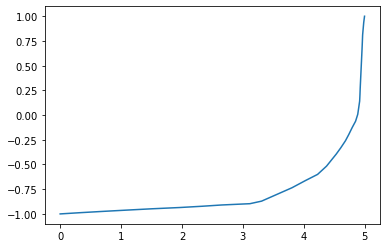

In [7]:
RCS_original= np.array([[-1, -0.987063428, -0.974129442, -0.961198042, -0.948269226, -0.935342994, -0.922419344, -0.909498275, -0.896579787, -0.870750547, -0.735315981, -0.664487066, -0.600164371, -0.51664037, -0.394760493, -0.330705304, -0.260317778, -0.196395511,-0.126153894, -0.062363997, 0.007732313, 0.071390387, 0.141341991, 0.204868786, 0.27467628, 0.338072335, 0.407736312, 0.471002165, 0.540523214, 0.603659398, 0.673038104, 0.73604515, 0.805282094, 0.817862672, 0.937256291, 1.000006639]])
t_strain_original=np.array([[0, 0.019998, 0.039992, 0.059982, 0.079968, 0.09995, 0.1199281, 0.1399021, 0.1598721, 0.1998003, 0.4091618, 0.5186527, 0.6180859, 0.7472015, 0.9356095, 1.0346292, 1.1434378, 1.242252, 1.350835, 1.4494446, 1.557803, 1.6562088, 1.7643435, 1.8625464, 1.9704583, 2.0684591, 2.1761492, 2.2739487, 2.3814178, 2.4790169, 2.586266,2.6836654, 2.7906953, 2.810143, 2.9947076, 3.0917103]])
t_stress_original= np.array([[0, 0.340068, 0.710284, 1.10066, 1.5012, 1.96196, 2.332796, 2.65371, 3.114976, 3.3066, 3.805539, 4.0208, 4.22604, 4.373075, 4.532206, 4.607424, 4.683245, 4.7385, 4.794328, 4.849788, 4.885517, 4.900661, 4.916864, 4.921744, 4.926117, 4.930947, 4.93626, 4.94109, 4.946403, 4.951233, 4.956546, 4.960832, 4.965274, 4.9666, 4.983792, 4.996952]])

RCS = RCS_original.T
t_strain=t_strain_original.T
t_stress = t_stress_original.T

plt.plot(t_stress , RCS)
plt.show()

In [8]:
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
        
    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)        
        self.dinputs = np.dot(dvalues, self.weights.T)
      
class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0  
      
class Activation_Linear:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = inputs
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()       
        
class Optimizer_Adam:
    def __init__(self, learning_rate=0.02, decay=0.0001, epsilon=1e-7, beta_1=0.9, beta_2=0.99):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
    
    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights        
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases  
        
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))       
        bias_momentums_corrected = layer.bias_momentums /(1 - self.beta_1 ** (self.iterations + 1))

        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2        
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2

        weight_cache_corrected = layer.weight_cache /(1 - self.beta_2 ** (self.iterations + 1))        
        bias_cache_corrected = layer.bias_cache /(1 - self.beta_2 ** (self.iterations + 1))

        layer.weights += -self.current_learning_rate *weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)   
        layer.biases += -self.current_learning_rate * bias_momentums_corrected /(np.sqrt(bias_cache_corrected) + self.epsilon)
        
    def post_update_params(self):
        self.iterations += 1
        
class Loss:
    
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss

class Loss_MeanSquaredError(Loss): 
    def forward(self, y_pred, y_true):
        sample_losses = np.mean((y_true - y_pred)**2, axis=-1)
        return sample_losses

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        self.dinputs = -2 * (y_true - dvalues) / outputs
        self.dinputs = self.dinputs / samples

In [9]:
dense1 = Layer_Dense(1, 64)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64, 64)
activation2 = Activation_ReLU()
dense3 = Layer_Dense(64, 1)
activation3 = Activation_Linear()
loss_function = Loss_MeanSquaredError()
optimizer = Optimizer_Adam()

accuracy_precision = np.std(RCS) / 250

for epoch in range(10000000):
    dense1.forward(t_stress)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    dense3.forward(activation2.output)
    activation3.forward(dense3.output)
    data_loss = loss_function.calculate(activation3.output, RCS)
    
    loss = data_loss 
    
    predictions = activation3.output
    accuracy = np.mean(np.absolute(predictions - RCS) <accuracy_precision)
    
    if not epoch % 1000:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy}, ' +
              f'loss: {loss} (' +
              f'data_loss: {data_loss}, ' +
              f'lr: {optimizer.current_learning_rate}')
    # Backward pass
    loss_function.backward(activation3.output, RCS)
    activation3.backward(loss_function.dinputs)
    dense3.backward(activation3.dinputs)
    activation2.backward(dense3.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)
    optimizer.post_update_params()
    

epoch: 0, acc: 0.0, loss: 831.9216399190295 (data_loss: 831.9216399190295, lr: 0.02
epoch: 1000, acc: 0.027777777777777776, loss: 0.16335736529312495 (data_loss: 0.16335736529312495, lr: 0.018183471224656786
epoch: 2000, acc: 0.0, loss: 0.2372245745228399 (data_loss: 0.2372245745228399, lr: 0.016668055671305942
epoch: 3000, acc: 0.0, loss: 0.4027924814658877 (data_loss: 0.4027924814658877, lr: 0.015385798907608278
epoch: 4000, acc: 0.0, loss: 0.07362483132196711 (data_loss: 0.07362483132196711, lr: 0.014286734766769053
epoch: 5000, acc: 0.0, loss: 0.3620184914479444 (data_loss: 0.3620184914479444, lr: 0.013334222281485434
epoch: 6000, acc: 0.0, loss: 0.06211709686815861 (data_loss: 0.06211709686815861, lr: 0.01250078129883118
epoch: 7000, acc: 0.05555555555555555, loss: 0.010558754401743246 (data_loss: 0.010558754401743246, lr: 0.011765397964586153
epoch: 8000, acc: 0.0, loss: 0.1117344576372677 (data_loss: 0.1117344576372677, lr: 0.011111728429357186
epoch: 9000, acc: 0.0, loss: 0.268

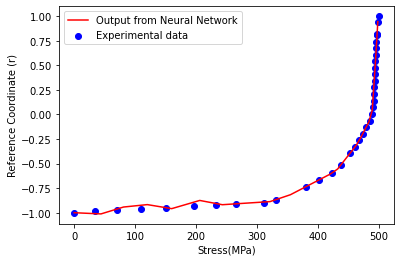

In [10]:
import matplotlib.pyplot as plt
X_test = np.array([[0, 0.440068, 0.810284, 1.20066, 1.6012, 2.06196, 2.432796, 2.75371, 3.214976, 3.55066, 4.035539, 4.21, 4.32604, 4.473075, 4.632206, 4.707424, 4.783245, 4.8385, 4.894328, 4.944788, 4.985517]])
X_test= X_test.T


dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
activation3.forward(dense3.output)


plt.scatter(t_stress*100 , RCS, color='blue', label='Experimental data')
plt.plot(X_test*100, activation3.output, color='red', label='Output from Neural Network')
plt.legend()

plt.xlabel("Stress(MPa)")
plt.ylabel("Reference Coordinate (r)")
plt.show()

In [80]:
dense1.forward(0.05)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
activation3.forward(dense3.output)

print(activation3.output)

[[-0.99027726]]
